In [70]:
import numpy as np
import pickle as cp

In [71]:
# Empty model

class EmptyModel:
    def log_prob(self, data):
        return 0
    
    def __str__(self):
        return 'empty-model'

In [72]:
# Bernoulli model

class BernoulliModel:
    def __init__(self, data):
        data = np.vectorize(int)(data)
        n = len(data) + 2
        zero_count = np.count_nonzero(data == 0) + 1
        one_count = np.count_nonzero(data == 1) + 1
        assert zero_count + one_count == n
        self.zero_log_prob = np.log(zero_count) - np.log(n)
        self.one_log_prob = np.log(one_count) - np.log(n)
        def lookup_one(n):
            n = int(n)
            if n == 0: return self.zero_log_prob
            elif n == 1: return self.one_log_prob
            else: return 0
        self.lookup = np.vectorize(lookup_one)
        
    def log_prob(self, data):
        return self.lookup(data)
    
    def __str__(self):
        return 'bernoulli-model(' + str(np.exp(self.one_log_prob)) + ')'

In [73]:
# Multinoulli model

class MultinoulliModel:
    def __init__(self, data, labels):
        n = len(data) + len(labels)
        curr_labels, counts = np.unique(data, return_counts=True)
        log_probs = np.log(counts + 1) - np.log(n)
        self.class_log_probs = dict(zip(curr_labels, log_probs))
        for lab in labels:
            if not lab in self.class_log_probs:
                self.class_log_probs[lab] =  - np.log(n)
        
        def lookup_one(lab):
            if lab in self.class_log_probs: return self.class_log_probs[lab]
            else: return 0
        self.lookup = np.vectorize(lookup_one)
        
    def log_prob(self, data):
        return self.lookup(data)
    
    def __str__(self):
        return 'multinoulli-model(' + str({k: np.exp(v) for (k, v) in sorted(self.class_log_probs.items())}) + ')'

In [74]:
# Gausian model

class GausianModel:
    def __init__(self, data):
        data = np.vectorize(float)(data)
        self.mean = np.mean(data)
        std = np.std(data)
        self.var = max(std ** 2, 1e-6)
        self.scale = - np.log(2 * np.pi * self.var) / 2
        
    def log_prob(self, data):
        data = np.vectorize(float)(data)
        return ( - (data - self.mean) ** 2 / (2 * self.var)) + self.scale
    
    def __str__(self):
        return 'gaussian-model(' + str(self.mean) + ', ' + str(np.sqrt(self.var)) + ')'

In [75]:
# Naive Bayes classifier

class NBC:
    def __init__(self, feature_types, missing=[]):
        self.feature_types = feature_types
        self.missing = missing
    
    def get_feature_prob(self, feature, label):
        model = models_by_class
    
    def fit(self, X, y):
        # set class probabilities
        labels, counts = np.unique(y, return_counts=True)
        log_probs = np.log(counts) - np.log(len(y))
        self.class_log_probs = dict(zip(labels, log_probs))
        self.labels = labels
        missing = self.missing
        
        # split data by classes
        X_by_class = dict()
        for lab in labels:
            indices = np.where(y == lab)[0]
            X_by_class[lab] = np.take(X, indices, axis=0)
        
        # find cathegorical feature classes
        num_features = len(self.feature_types)
        feature_lables = dict()
        for i in range(num_features):
            if self.feature_types[i] == 'c':
                data = X[:, i]
                if len(missing) > i:
                    ms = missing[i]
                    data = data[data != ms]
                feature_lables[i] = np.unique(data)
        
        # fit models
        self.models = dict()
        for lab in labels:
            self.models[lab] = list()
            for i in range(num_features):
                data = X_by_class[lab][:, i]
                if len(missing) > i:
                    ms = missing[i]
                    data = data[data != ms]
                feature_type = self.feature_types[i]
                if feature_type == 'n':
                    model = EmptyModel()
                elif feature_type == 'b':
                    model = BernoulliModel(data)
                elif feature_type == 'c':
                    model = MultinoulliModel(data, feature_lables[i])
                elif feature_type == 'r':
                    model = GausianModel(data)
                else:
                    model = EmptyModel()
                    raise Exception('Unknown feature type {}.'.format(feature_type))
                self.models[lab].append(model)
    
    def predict(self, X):
        n = len(self.feature_types)
        def get_lab_log_prob(lab):  
            models = self.models[lab]
            def get_feature_log_prob(i):
                return models[i].log_prob(X[:, i])
            flps = np.array(list(map(get_feature_log_prob, np.arange(n))))
            return np.sum(flps, axis=0) + self.class_log_probs[lab]
        lab_log_probs = np.array(list(map(get_lab_log_prob, self.labels)))
        lab_idxs = np.argmax(lab_log_probs, axis=0)
        return self.labels[lab_idxs]
    
    def __str__(self):
        return str(self.models)

In [76]:
# Shuffle a dataset

def shuffle_dataset(X, y):
    N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    return Ntrain, Xtrain, ytrain, Xtest, ytest

In [77]:
# Find learning curve

intervals = 10

def learning_curve_round(model, X, y):
    Ntrain, Xtrain, ytrain, Xtest, ytest = shuffle_dataset(X, y)
    result = list()
    for i in range(intervals):
        N = int(Ntrain * (i + 1) / intervals)
        model.fit(Xtrain[:N], ytrain[:N])
        yhat = model.predict(Xtest)
        test_error = np.mean(yhat != ytest)
        result.append(test_error)
    return np.array(result)

def learning_curve(model, X, y, iters=200):
    result = list()
    for i in range(iters):
        result.append(learning_curve_round(model, X, y))
    return np.mean(np.array(result), axis=0)

In [78]:
# Plot learning curves

import matplotlib.pyplot as plt

def plot_learning_curves(title, triples, iters=200):
    xs = (np.arange(intervals) + 1) * 100 / intervals
    for (model, X, y) in triples:
        plt.plot(xs, learning_curve(model, X, y, iters))
    plt.title(title)
    plt.show()

In [143]:
# One hot encoder

def one_hot_encode(X, encode_features, missing=[]):
    n, m = X.shape
    new_features = list()
    features = list(X.transpose())
    for i in range(m):
        feature = features[i]
        if encode_features[i] == 'n':
            new_features.append(feature)
        else:
            labels = np.unique(feature)
            if len(missing) > i:
                labels = labels[labels != missing[i]]
            for lab in labels:
                new_features.append(np.equal(feature, np.full(n, lab)))
    return np.array(new_features).transpose()

In [141]:
# Logistic regression classifier

from sklearn.linear_model import LogisticRegression

lrc = LogisticRegression(C=5.0, multi_class='ovr', solver='liblinear')

In [81]:
# Load iris dataset

from sklearn.datasets import load_iris

def load_iris_dataset():
    iris = load_iris()
    return iris['data'], iris['target']

In [82]:
# Load voting dataset

def load_voting_dataset():
    return cp.load(open('voting.pickle', 'rb'))

def load_full_voting_dataset():
    return cp.load(open('voting_full.pickle', 'rb'))

In [83]:
# Load adult dataset

def load_adult_dataset():
    return cp.load(open('adult.pickle', 'rb'))

def load_full_adult_dataset():
    return cp.load(open('adult_full.pickle', 'rb'))

def load_ugly_adult_dataset():
    return cp.load(open('adult_ugly.pickle', 'rb'))

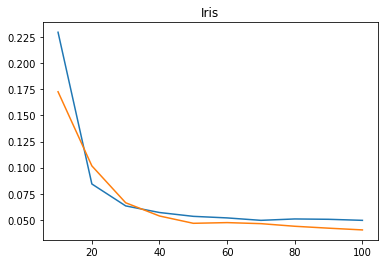

In [84]:
X, y = load_iris_dataset()
nbc = NBC(feature_types='rrrr')
plot_learning_curves('Iris', [(nbc, X, y), (lrc, X, y)])

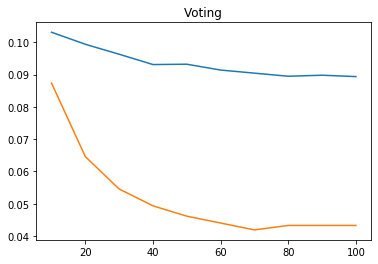

In [161]:
X, y = load_voting_dataset()
nbc = NBC(feature_types='bbbbbbbbbbbbbbbb')
plot_learning_curves('Voting', [(nbc, X, y), (lrc, X, y)])

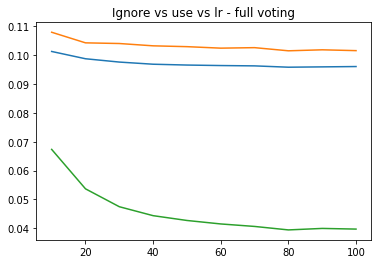

In [110]:
X, y = load_full_voting_dataset()
X_ohe = one_hot_encode(X, 'yyyyyyyyyyyyyyyy',  missing=np.repeat(2, 16))
nbc_i = NBC(feature_types='bbbbbbbbbbbbbbbb', missing=np.repeat(2, 16))
nbc_u = NBC(feature_types='cccccccccccccccc')
plot_learning_curves('Ignore vs use vs lr - full voting', [(nbc_i, X, y), (nbc_u, X, y), (lrc, X_ohe, y)])

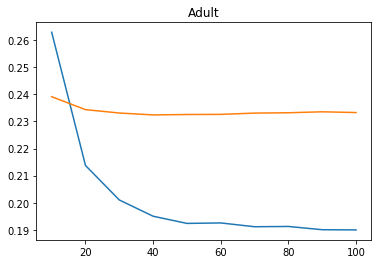

In [160]:
X , y = load_adult_dataset()
X = X[:1000]
y = y[:1000]
X_ohe = one_hot_encode(X, 'nynynyyyyynnny')
nbc = NBC(feature_types='rcrcrcccccrrrc')
plot_learning_curves('Adult', [(nbc, X, y), (lrc, X_ohe, y)])

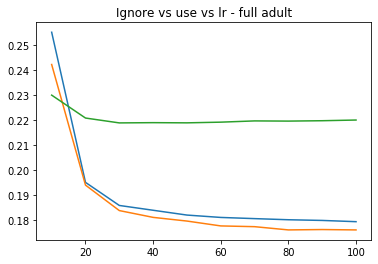

In [164]:
X , y = load_full_adult_dataset()
X = X[:1000]
y = y[:1000]
X_ohe = one_hot_encode(X, 'nynynyyyyynnny',  missing=np.repeat(-1, 16))
nbc_i = NBC(feature_types='rcrcrcccccrrrc', missing=np.repeat(-1, 16))
nbc_u = NBC(feature_types='rcrcrcccccrrrc')
plot_learning_curves('Ignore vs use vs lr - full adult', [(nbc_i, X, y), (nbc_u, X, y), (lrc, X_ohe, y)])

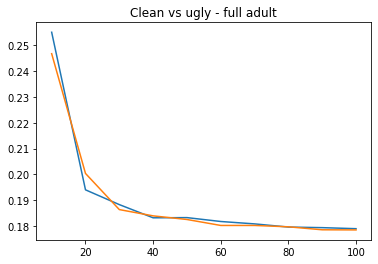

In [166]:
X_c , y_c = load_full_adult_dataset()
X_c = X_c[:1000]
y_c = y_c[:1000]
X_u, y_u = load_ugly_adult_dataset()
X_u = X_u[:1000]
y_u = y_u[:1000]
nbc_c = NBC(feature_types='rcrcrcccccrrrc', missing=np.repeat(-1, 16))
nbc_u = NBC(feature_types='rcrcrcccccrrrc', missing=np.repeat('?', 16))
plot_learning_curves('Clean vs ugly - full adult', [(nbc_c, X_c, y_c), (nbc_u, X_u, y_u)])

In [158]:
X_u, y_u = load_ugly_adult_dataset()
print(X_u[0], y_u[0])

['27' 'Private' '177119' 'Some-college' '10' 'Divorced' 'Adm-clerical'
 'Unmarried' 'White' 'Female' '0' '0' '44' 'United-States'] <=50K
